In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import ParameterGrid
import torch.utils.data as data_utils
from nltk.tokenize import word_tokenize
from collections import defaultdict
import torch.optim as optim
from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_file(path):
    with open(path, 'rb') as f:
        arr = np.load(f)
    return arr

def labels_2(nums):
    if nums > 0:
        return 1
    return 0

In [5]:
X_train_bert, X_val_bert, X_test_bert = (load_file('models/bert_train.npy'), 
                                         load_file('models/bert_val.npy'), 
                                         load_file('models/bert_test.npy'))
X_train_wav, X_val_wav, X_test_wav = (load_file('models/wav2vec_v3_train.npy'), 
                                         load_file('models/wav2vec_v3_val.npy'), 
                                         load_file('models/wav2vec_v3_test.npy'))

In [6]:
y_train_bert, y_val_bert, y_test_bert = (pd.read_csv('models/train_bert.csv')['sentiment'].apply(labels_2).values, 
                                         pd.read_csv('models/val_bert.csv')['sentiment'].apply(labels_2).values, 
                                         pd.read_csv('models/test_bert.csv')['sentiment'].apply(labels_2).values)

In [7]:
y_train_bert.shape, X_train_bert.shape, X_train_wav.shape

((16274,), (16274, 768), (16274, 768))

In [8]:
X_train_bert.shape, X_train_wav.shape

((16274, 768), (16274, 768))

# BaseLine Test

In [12]:
def models_fit(X_train, y_train):
    
    classify_models = [
    LogisticRegression(penalty='l2', C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, solver='lbfgs'),
    SVC(C=1.0, kernel='rbf', cache_size=200, class_weight=None, probability=True),
    GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=100, criterion='friedman_mse'),
    RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True, oob_score=False), 
    BernoulliNB()
    ]

    classify_names = [
        'LogisticRegression',
        'SVC',
        'GradientBoostingClassifier',
#         'RandomForestClassifier',
        'BernoulliNB'
    ]

    for i, (m, n) in enumerate(zip(classify_models, classify_names)):
        model = m
        model.fit(X_train, y_train)
        print(f'{n} is fitted')
    
    return classify_models, classify_names


def metrics_plot(X_test, y_test, classify_models, classify_names, metric):
    
    sns.set(font_scale=1.2)
    
    if metric == 'classification_report': _, ax = plt.subplots(1, 5, figsize=(23, 3), sharey=True)
    if metric == 'roc-auc': _, ax = plt.subplots(1, 5, figsize=(24, 3), sharey=True)
    if metric == 'confusion_matrix': _, ax = plt.subplots(1, 5, figsize=(24, 3), sharey=True)
    
    for i, (m, n) in enumerate(zip(classify_models, classify_names)):
        
        if metric == 'classification_report':
            sns.heatmap(pd.DataFrame(classification_report(y_test, m.predict(X_test), output_dict=True)).T,
                            annot=True, ax=ax[i])
        if metric == 'roc-auc':
            plot_roc_curve(y_test, m.predict_proba(X_test), ax=ax[i])
        
        if metric == 'confusion_matrix':
            plot_confusion_matrix(y_test, m.predict(X_test), ax=ax[i], normalize='true')
            ax[i].grid(False)
            
        ax[i].set_title(f'{n}')

## Bert

In [7]:
classify_models, classify_names = models_fit(X_train_bert, y_train_bert)

LogisticRegression is fitted
SVC is fitted
GradientBoostingClassifier is fitted
RandomForestClassifier is fitted
BernoulliNB is fitted


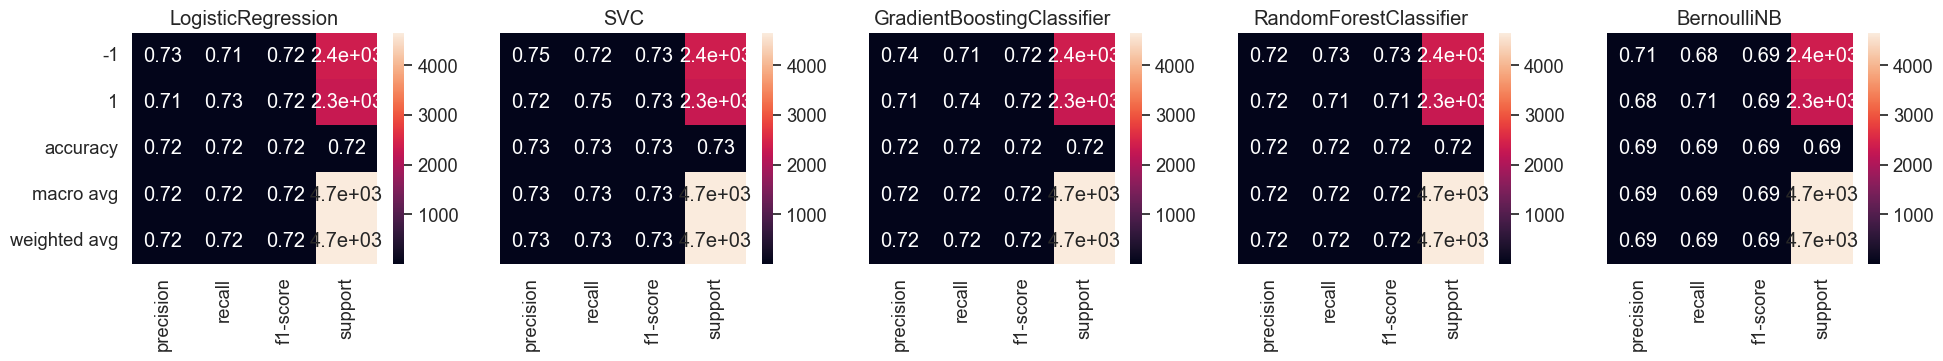

In [9]:
metrics_plot(X_test_bert, y_test_bert, classify_models, classify_names, 'classification_report')

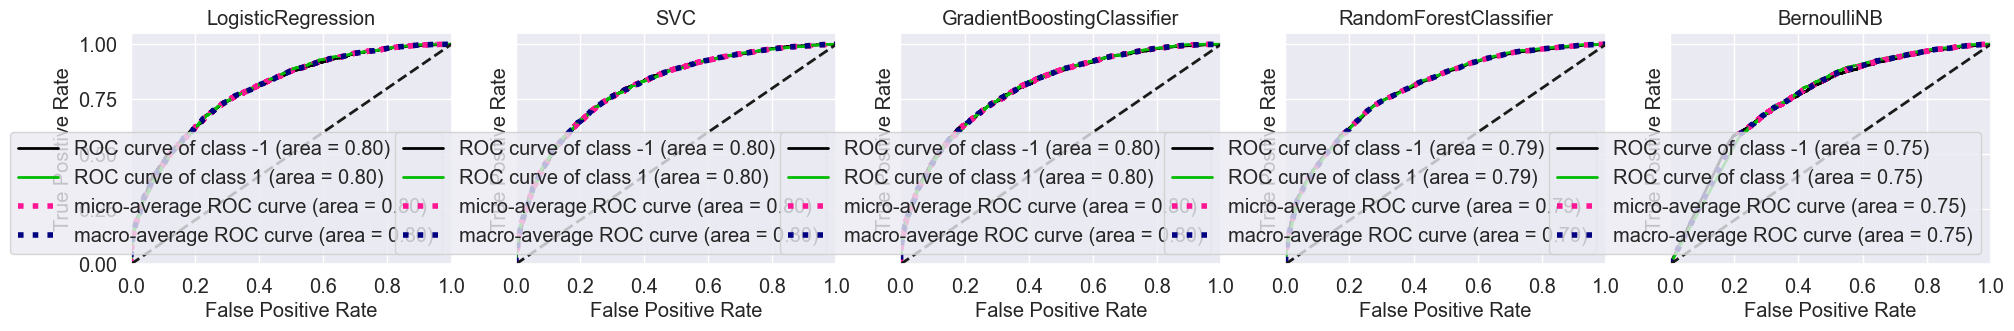

In [10]:
metrics_plot(X_test_bert, y_test_bert, classify_models, classify_names, 'roc-auc')

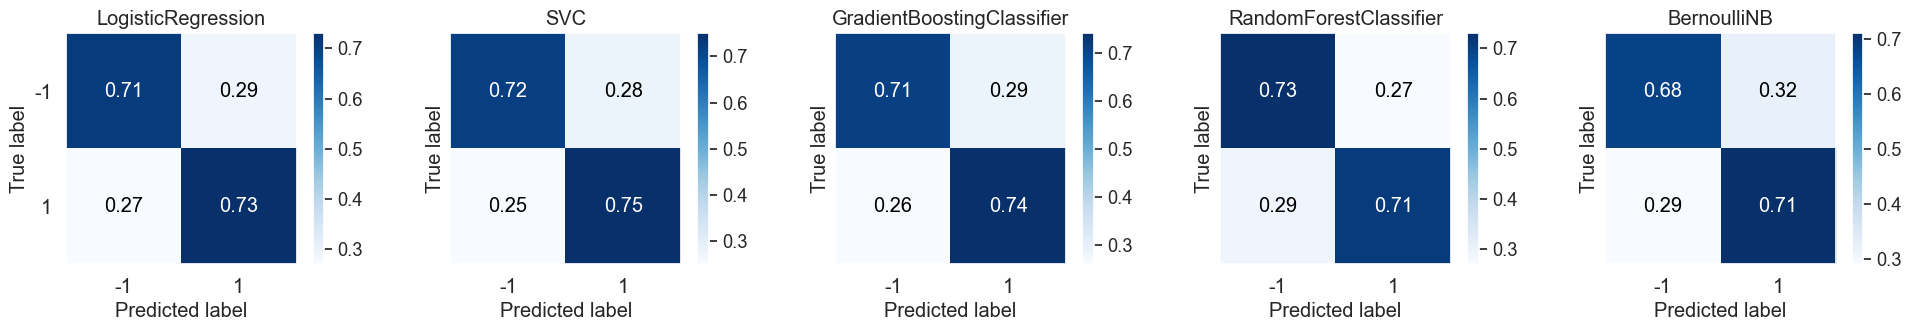

In [11]:
metrics_plot(X_test_bert, y_test_bert, classify_models, classify_names, 'confusion_matrix')

## WAV2VEC

In [13]:
classify_models, classify_names = models_fit(X_train_wav, y_train_bert)

LogisticRegression is fitted
SVC is fitted
GradientBoostingClassifier is fitted
BernoulliNB is fitted


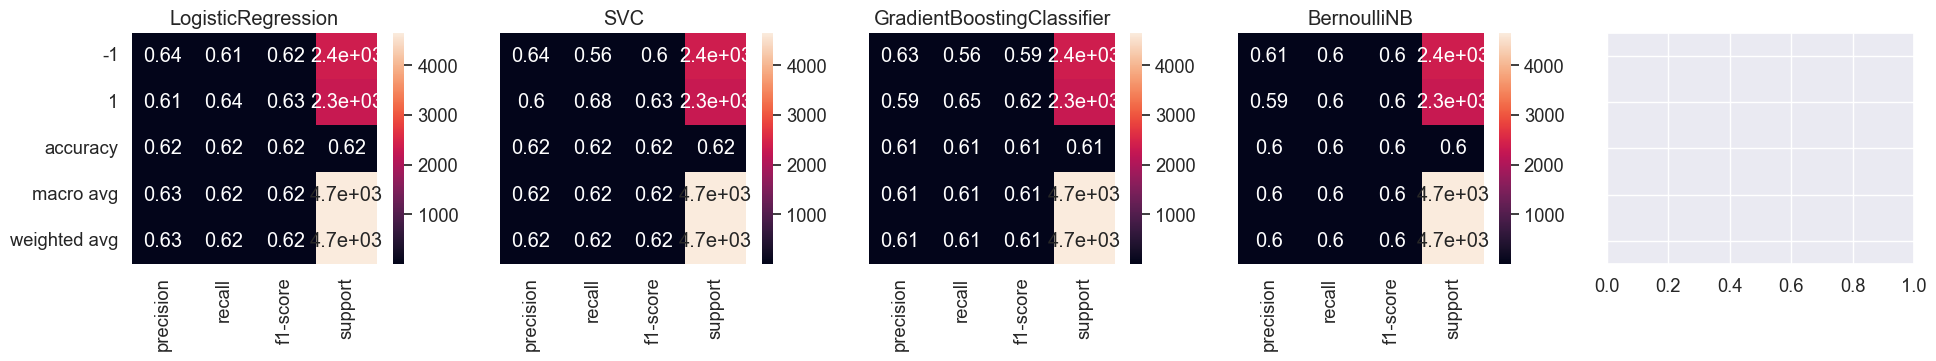

In [14]:
metrics_plot(X_test_wav, y_test_bert, classify_models, classify_names, 'classification_report')

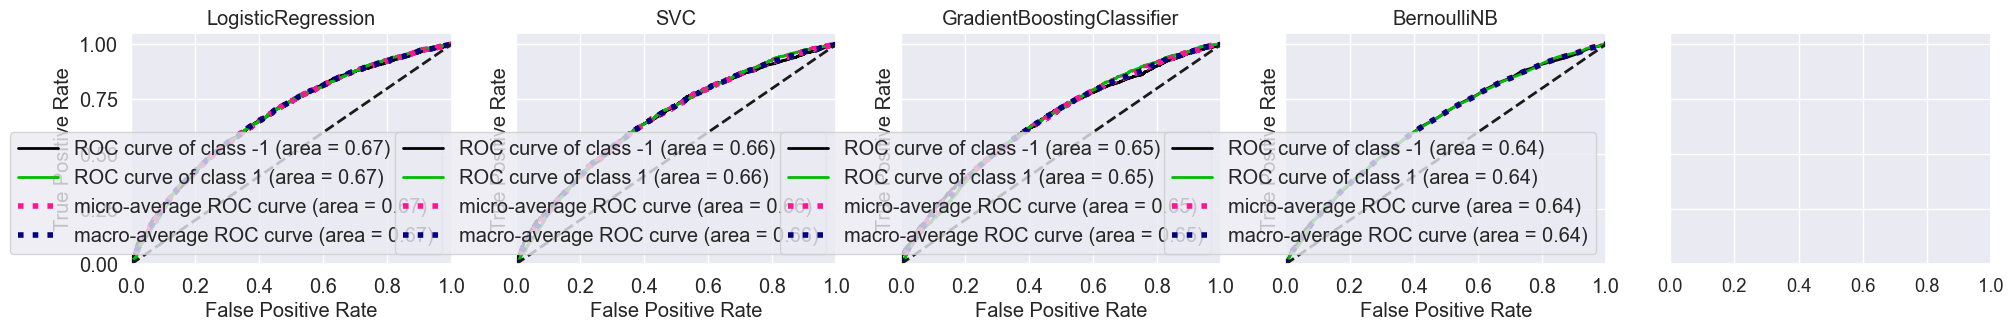

In [15]:
metrics_plot(X_test_wav, y_test_bert, classify_models, classify_names, 'roc-auc')

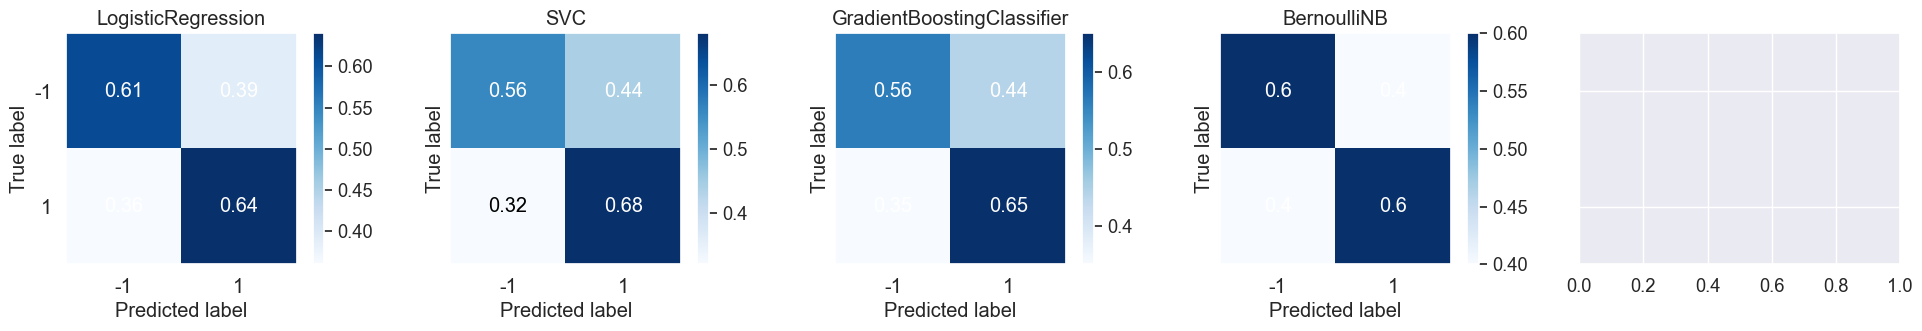

In [16]:
metrics_plot(X_test_wav, y_test_bert, classify_models, classify_names, 'confusion_matrix')

# DL-models: CNN + RNN

В данной работе для классификации тональности используются сверточные слои с последующим использованием реккурентных слоев. 

- **`CNN`**

Свертка двух функций $f, g$ это:

$|f \odot g|(z)=\int_R f(u)g(z-u) \: du$

В дискретном случае для $w, x$:

$[w \odot x](i) = \sum_{u=0}^{L-1} w_u x_{i+u}$

Свертку можно рассматривать как процесс сопоставления с шаблоном, так как если результат операции значим, то патч данных похож на ядро. Таким образом, функция свертки интерпретируется как форма выявления признаков, а выходные данные называются картой признаков. 

Свертка $y$ как линейный оператор может быть переписана: 

$y=Cx=\begin{pmatrix} 
w_1 & w_2 & 0 & w_3 & w_4 & 0 & 0 & 0 & 0 \\
0 & w_1 & w_2 & 0 & w_3 & w_4 & 0 & 0 & 0 \\
0 & 0 & 0 & w_1 & w_2 & 0 & w_3 & w_4 & 0 \\
0 & 0 & 0 & 0 & w_1 & w_2 & 0 & w_3 & w_4 \\
\end{pmatrix}
\begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7 \\ x_8 \\ x_9  \end{pmatrix}$, 

где $C$ - матрица Теплица, выведенная из ядра $W_{2,2}$, $x$ - вектор, полученный из матрицы $X_{3,3}$

Из записи выше видно, что матрица весов имеет специальную разреженную структуру и элементы связаны в пространственных направлениях. Таким образом число параметров сокращается в зависимости от плотных слоев, а также реализуется принцип инвариантности к сдвигу. При этом свертка с шагом необходима для уменьшения избыточности на выходе свертки, так как соседние выходные пиксели имеют близкие значения. Также обычно ядро определяют для каждого входного канала, и каждая матрица весов выявляет один вид признаков. 

Сверточные сети предпочтительнее плотных за счет того, что последние не инварианты относительно сдвига (нет разделения весов между позициями).
Одномерные сверточные сети можно использовать для классификации последовательностей, предварительно вычислив эмбеддинг каждого слова, а затем производить расчет различных признаков с использованием одномерных ядер разной шириным стремять уловить паттерны. В конце применяется max-pooling по времени, результаты конкатенируются и передаются полносвязанному слою. 

- **`RNN`**

Реккурентная нейронная сеть отображает пространство входных последовательностей в пространство выходных последовательностей, сохраняя информацию о состоянии (скрытое состояние системы, которое обновляется со временем по мере обработки последовательности). 

Рекуррентные модели с достаточным числом скрытых блоков способны хорошо запоминать входные данные во времени, однако может возникнуть проблема исчезающего градиента. Одним из способов решения этой проблемы - использование управляемых реккурентных блоков (*GRU*). Их основная идея - обучиться обновлять скрытое состояние путем избирательного "запоминания" важных частей информации и "сбрасывания" ненужной информации.

Пусть $X_t$ - входная матрица, $H_t$ - матрица со скрытыми блоками в момент времени $t$, $W$ - матрица весов. Тогда *Вентиль сброса* $R_t \in \mathbb{R}_{N,H}$ (может уловить новую краткосрочную информацию) и *Вентиль обновления* $Z_{t} \in \mathbb{R}_{N,H}$ (может уловить долгосрочные зависимости):

$R_t=\sigma(X_tW_{xr}+H_{t-1}W_{hr}+b_{r})$

$Z_{t}=\sigma(X_tW_{xz}+H_{t-1}W_{hz}+b_{z})$

Определим следующий кондидат на вектор состояния $\tilde H_t = \tanh(X_tW_{xh}+(R_t \odot H_{t-1})W_{hh}+b_{h})$

Вычислим новое состояние $H_t = Z_t \odot H_{t-1} + (1-Z_t) \odot \tilde H_t$

**В данной** работе было решено использовать сначала сверточные сети для фильтрации входных данных и создания карты признаков с выявленными паттернами в данных. Далее используется рекуррентная сеть для учета временной структуры текста/аудио.

In [9]:
def fit(net, num_epoch, trainset, optimizer, lr):
    optimizer = optimizer(net.parameters(), lr=lr)
    for epoch in range(num_epoch):
        for data in trainset:
            X, y = data
            net.zero_grad()
            output = net(X)
            loss = F.cross_entropy(output, y.long())
            loss.backward()
            optimizer.step()
    return net

def predict(net, testset, prob=False):
    ans = []
    with torch.no_grad():
        for data in testset:
            X, y = data
            output = net(X)
            for idx, pred in enumerate(output):
                res = pred.cpu().data.numpy()
                res = res if prob else res.argmax().item()
                ans.append(res)
    return ans

In [10]:
class SentCRClf(nn.Module):
    
    def __init__(self,
                 embed_dim=None,
                 conv_layer_count=None, 
                 stride=None,
                 kernel_size=None,
                 type_rnn=None,
                 hidden_size=None, 
                 bidirectional=None,
                 rnn_layer_count=None):
        super().__init__()
        self.embed_dim = embed_dim
        
        self.conv1d_layers = nn.ModuleList([])
        out_shape = 1
        padding = kernel_size // 2
        for i in range(conv_layer_count):
            self.conv1d_layers.append(nn.Conv1d(in_channels=embed_dim,
                                                out_channels=embed_dim,
                                                kernel_size=kernel_size,
                                                stride=stride, 
                                                padding=padding))
            out_shape = 1 + (out_shape + 2 * padding - kernel_size) // stride
        
        self.rnn = type_rnn(
            input_size=self.embed_dim,
            hidden_size=hidden_size,
            num_layers=rnn_layer_count,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size * out_shape * (1 + bidirectional), 2)

    def forward(self, x):
        x = x[:, :, None]
        for conv_layer in self.conv1d_layers:
            x = F.relu(conv_layer(x))
        x = x.reshape(len(x), -1, self.embed_dim)
        x, _ = self.rnn(x)
        x = x.reshape(x.shape[0], -1)
        logits = self.fc(x)
        return F.log_softmax(logits, dim=-1)

In [13]:
param_grid = {
    "embeddings": ['bert', 'wav2vec'],
    "label": [(y_train_bert, y_val_bert, y_test_bert)],
    "lr": [3e-4],
    "epochs": [5, 10, 15],
    "optimizer": [optim.AdamW],
    "batch_size": [4096],
    "cnn_layers_count": [3, 5, 10],
    "kernel_size": [3, 5],
    "stride": [1, 3],
    "type_rnn": [torch.nn.LSTM],
    "bidirectional": [True],
    "hidden_size": [100, 300, 400],
    "rnn_layers_count": [3, 5, 10],
}
params_list = ParameterGrid(param_grid)
len(params_list)

648

In [14]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)

configs = []
max_score = 0
preds = []
probs = []

for params in tqdm(params_list):
    
    # get param for pass to network
    
    if params["embeddings"] == 'bert':
        X_train, X_val, X_test = X_train_bert, X_val_bert, X_test_bert
    else:
        X_train, X_val, X_test = X_train_wav, X_val_wav, X_test_wav
    y_train, y_val, y_test = params['label']
    lr = params['lr']
    epochs = params['epochs']
    optimizer = params['optimizer']
    batch_size = params['batch_size']
    
    kernel_size = params['kernel_size']
    stride = params['stride']
    cnn_layers_count = params['cnn_layers_count']
    
    type_rnn = params["type_rnn"]
    bidirectional = params["bidirectional"]
    hidden_size = params["hidden_size"]
    rnn_layers_count = params['rnn_layers_count']
    
    inputs_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    targets_train = torch.tensor(y_train, dtype=torch.int32).to(device)

    inputs_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    targets_test = torch.tensor(y_test, dtype=torch.int32).to(device)
    
    inputs_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    targets_val = torch.tensor(y_val, dtype=torch.int32).to(device)

    train = data_utils.TensorDataset(inputs_train, targets_train)
    test = data_utils.TensorDataset(inputs_test, targets_test)
    val = data_utils.TensorDataset(inputs_val, targets_val)

    trainset = torch.utils.data.DataLoader(train, shuffle=True, batch_size=batch_size)
    testset = torch.utils.data.DataLoader(test, shuffle=False, batch_size=batch_size)
    valtset = torch.utils.data.DataLoader(val, shuffle=False, batch_size=batch_size)
    
    # net build
    net = SentCRClf(
                      embed_dim=X_train.shape[1], 
                      conv_layer_count=cnn_layers_count, 
                      stride=stride, 
                      kernel_size=kernel_size,
                      type_rnn=type_rnn,
                      hidden_size=hidden_size, 
                      bidirectional=bidirectional,
                      rnn_layer_count=rnn_layers_count
    )
    net.to(device)

    # fit
    net = fit(net, epochs, trainset, optimizer, lr)
    
    # predict
    ans_test = predict(net, testset)
    ans_val = predict(net, valtset)
    
    score_test = f1_score(y_test, ans_test, average="weighted")
    score_ = f1_score(y_val, ans_val, average="weighted")
    if score_ > max_score:
        max_score = score_
        preds = ans_test
        probs = predict(net, testset, prob=True)
    
    # add param in config
    config = [params["embeddings"], epochs, optimizer.__name__, batch_size, cnn_layers_count, kernel_size, stride, 
              type_rnn.__name__, bidirectional, hidden_size, rnn_layers_count, f'{score_test:.5f}', f'{score_:.5f}']
    configs.append(config)
    

df = pd.DataFrame(configs)
df.columns = ['embeddings', 'epochs', 'optimizer', 'batch_size', 'cnn_layers_count', 'kernel_size', 'stride', 
              'type_rnn', 'bidirectional', 'hidden_size', 'rnn_layers_count', 'f1_score_test', 'f1_score_val']
df.sort_values(by='f1_score_val', ascending=False).reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [38:37<00:00,  3.58s/it]


,embeddings,epochs,optimizer,batch_size,cnn_layers_count,kernel_size,stride,type_rnn,bidirectional,hidden_size,rnn_layers_count,f1_score_test,f1_score_val
0,bert,15,AdamW,4096,5,3,3,LSTM,True,100,3,0.72569,0.71682
1,bert,15,AdamW,4096,3,5,1,LSTM,True,400,3,0.72536,0.71614
2,bert,15,AdamW,4096,5,3,1,LSTM,True,100,3,0.72192,0.71513
3,bert,15,AdamW,4096,3,3,1,LSTM,True,100,3,0.72784,0.71467
4,bert,15,AdamW,4096,3,3,3,LSTM,True,400,3,0.72558,0.71402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,wav2vec,5,AdamW,4096,5,3,3,LSTM,True,100,5,0.34401,0.33363
644,wav2vec,5,AdamW,4096,5,3,1,LSTM,True,100,5,0.34401,0.33363
645,bert,15,AdamW,4096,5,5,3,LSTM,True,400,10,0.34401,0.33363
646,bert,15,AdamW,4096,5,5,1,LSTM,True,400,10,0.34401,0.33363


### Test

<Axes: >

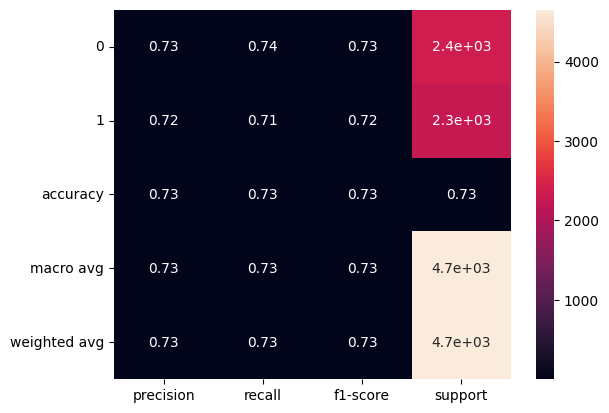

In [15]:
sns.heatmap(pd.DataFrame(classification_report(y_test, preds, output_dict=True)).T, annot=True)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

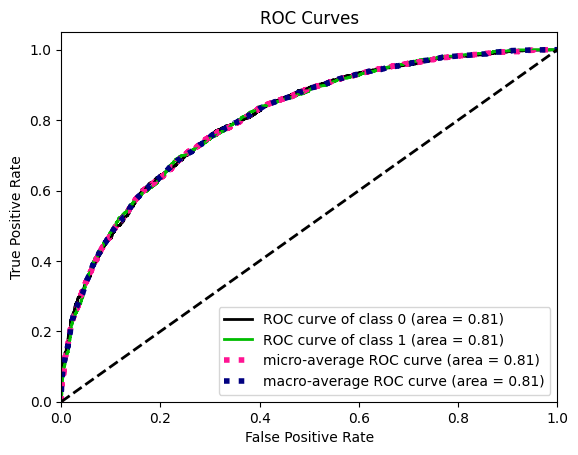

In [16]:
plot_roc_curve(y_test, np.expand_dims(probs, -1))

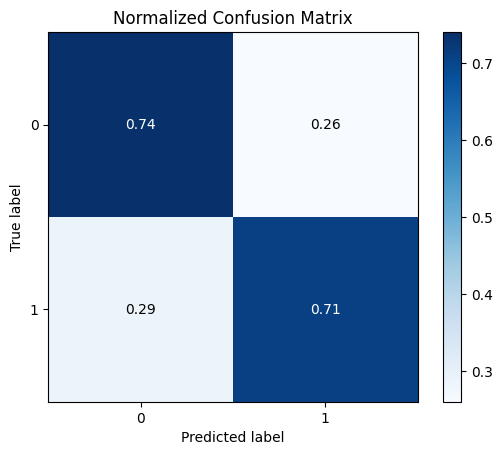

In [17]:
plot_confusion_matrix(y_test, preds, normalize='true')
plt.grid(False)

### Выводы
После проведения экперимента было выявлено, что усложнение модели не дает прироста в метриках, сходимости модели, вероятно, препятсвует большое количество оптимизируемых параметров и малое количество данных. 

# Fusion 

In [12]:
# 1) сначала сливаются - а потом подаются в сеть
# 2) подаются в сеть а потом сливаются 

In [18]:
class SentCRClf_with_Fusion(nn.Module):
    
    def __init__(self,
                 embed_dim=None,
                 conv_layer_count=None, 
                 stride=None,
                 kernel_size=None,
                 type_rnn=None,
                 hidden_size=None, 
                 bidirectional=None,
                 rnn_layer_count=None,
                 fusion=False):
        super().__init__()
        self.embed_dim = embed_dim
        padding = kernel_size // 2
        self.fusion = fusion
        if self.fusion:
            self.conv_x1 = nn.ModuleList([])
            self.conv_x2 = nn.ModuleList([])
            out_shape = 1
            for i in range(2):
                self.conv_x1.append(nn.Conv1d(in_channels=self.embed_dim // 2,
                                                out_channels=self.embed_dim // 2,
                                                kernel_size=kernel_size,
                                                stride=stride, 
                                                padding=padding))
                self.conv_x2.append(nn.Conv1d(in_channels=self.embed_dim // 2,
                                                out_channels=self.embed_dim // 2,
                                                kernel_size=kernel_size,
                                                stride=stride, 
                                                padding=padding))
                out_shape = 1 + (out_shape + 2 * padding - kernel_size) // stride
            self.proj_text = nn.Linear(out_shape * self.embed_dim // 2, 64)
            self.proj_audio = nn.Linear(out_shape * self.embed_dim // 2, 64)
            self.embed_dim = 128
        
        self.conv1d_layers = nn.ModuleList([])
        out_shape = 1
        for i in range(conv_layer_count):
            self.conv1d_layers.append(nn.Conv1d(in_channels=self.embed_dim,
                                                out_channels=self.embed_dim,
                                                kernel_size=kernel_size,
                                                stride=stride, 
                                                padding=padding))
            out_shape = 1 + (out_shape + 2 * padding - kernel_size) // stride
        
        self.rnn = type_rnn(
            input_size=self.embed_dim,
            hidden_size=hidden_size,
            num_layers=rnn_layer_count,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size * out_shape * (1 + bidirectional), 2)

    def forward(self, x):
        
        if self.fusion:
            x1, x2 = x[..., :768], x[..., 768:]
            x1 = self.proj_text(x1)
            x2 = self.proj_audio(x2)
            x = torch.concat([x1, x2], axis=-1)
         
        x = x[:, :, None]
        for conv_layer in self.conv1d_layers:
            x = F.relu(conv_layer(x))
        x = x.reshape(len(x), -1, self.embed_dim)
        x, _ = self.rnn(x)
        x = x.reshape(x.shape[0], -1)
        logits = self.fc(x)
        return F.log_softmax(logits, dim=-1)

In [19]:
param_grid = {
    "label": [(y_train_bert, y_val_bert, y_test_bert)],
    "lr": [3e-4],
    "epochs": [5, 10, 15],
    "optimizer": [optim.AdamW],
    "batch_size": [4096],
    "cnn_layers_count": [3, 5, 10],
    "kernel_size": [3, 5],
    "stride": [1, 3],
    "type_rnn": [torch.nn.LSTM],
    "bidirectional": [True],
    "hidden_size": [100, 300, 400],
    "rnn_layers_count": [3, 5, 10],
    'fusion': [False, True]
}
params_list = ParameterGrid(param_grid)
len(params_list)

648

In [20]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)

configs = []
max_score = 0
preds = []
probs = []

X_train = np.concatenate([X_train_bert, X_train_wav], axis=1)
X_test = np.concatenate([X_test_bert, X_test_wav], axis=1)
X_val = np.concatenate([X_val_bert, X_val_wav], axis=1)

inputs_train = torch.tensor(X_train, dtype=torch.float32).to(device)
targets_train = torch.tensor(y_train, dtype=torch.int32).to(device)

inputs_test = torch.tensor(X_test, dtype=torch.float32).to(device)
targets_test = torch.tensor(y_test, dtype=torch.int32).to(device)
    
inputs_val = torch.tensor(X_val, dtype=torch.float32).to(device)
targets_val = torch.tensor(y_val, dtype=torch.int32).to(device)

train = data_utils.TensorDataset(inputs_train, targets_train)
test = data_utils.TensorDataset(inputs_test, targets_test)
val = data_utils.TensorDataset(inputs_val, targets_val)

trainset = torch.utils.data.DataLoader(train, shuffle=True, batch_size=batch_size)
testset = torch.utils.data.DataLoader(test, shuffle=False, batch_size=batch_size)
valtset = torch.utils.data.DataLoader(val, shuffle=False, batch_size=batch_size)

for params in tqdm(params_list):
    
    # get param for pass to network

    y_train, y_val, y_test = params['label']
    lr = params['lr']
    epochs = params['epochs']
    optimizer = params['optimizer']
    batch_size = params['batch_size']
    fusion = params['fusion']
    
    kernel_size = params['kernel_size']
    stride = params['stride']
    cnn_layers_count = params['cnn_layers_count']
    
    type_rnn = params["type_rnn"]
    bidirectional = params["bidirectional"]
    hidden_size = params["hidden_size"]
    rnn_layers_count = params['rnn_layers_count']
    
    # net build
    net = SentCRClf_with_Fusion(
                      embed_dim=X_train.shape[1], 
                      conv_layer_count=cnn_layers_count, 
                      stride=stride, 
                      kernel_size=kernel_size,
                      type_rnn=type_rnn,
                      hidden_size=hidden_size, 
                      bidirectional=bidirectional,
                      rnn_layer_count=rnn_layers_count,
                      fusion=fusion
    )
    net.to(device)

    # fit
    net = fit(net, epochs, trainset, optimizer, lr)
    
    # predict
    ans_test = predict(net, testset)
    ans_val = predict(net, valtset)
    
    score_test = f1_score(y_test, ans_test, average="weighted")
    score_ = f1_score(y_val, ans_val, average="weighted")
    if score_ > max_score:
        max_score = score_
        preds = ans_test
        probs = predict(net, testset, prob=True)
    
    # add param in config
    config = [fusion, epochs, optimizer.__name__, batch_size, cnn_layers_count, kernel_size, stride, 
              type_rnn.__name__, bidirectional, hidden_size, rnn_layers_count, f'{score_test:.5f}', f'{score_:.5f}']
    configs.append(config)
    

df = pd.DataFrame(configs)
df.columns = ['fusion', 'epochs', 'optimizer', 'batch_size', 'cnn_layers_count', 'kernel_size', 'stride', 
              'type_rnn', 'bidirectional', 'hidden_size', 'rnn_layers_count', 'f1_score_test', 'f1_score_val']
df.sort_values(by='f1_score_val', ascending=False).reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [45:03<00:00,  4.17s/it]


,fusion,epochs,optimizer,batch_size,cnn_layers_count,kernel_size,stride,type_rnn,bidirectional,hidden_size,rnn_layers_count,f1_score_test,f1_score_val
0,False,15,AdamW,4096,3,3,3,LSTM,True,400,5,0.72976,0.72165
1,False,15,AdamW,4096,3,5,1,LSTM,True,300,5,0.72615,0.72126
2,False,15,AdamW,4096,5,3,1,LSTM,True,300,3,0.72638,0.72000
3,False,15,AdamW,4096,3,5,3,LSTM,True,400,3,0.72987,0.71937
4,False,15,AdamW,4096,3,5,3,LSTM,True,400,5,0.72564,0.71915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,True,10,AdamW,4096,5,3,1,LSTM,True,400,10,0.34401,0.33363
644,True,10,AdamW,4096,5,3,3,LSTM,True,400,5,0.34401,0.33363
645,True,10,AdamW,4096,5,3,1,LSTM,True,400,5,0.34401,0.33363
646,True,15,AdamW,4096,10,5,3,LSTM,True,400,10,0.34401,0.33363


## Test 


<Axes: >

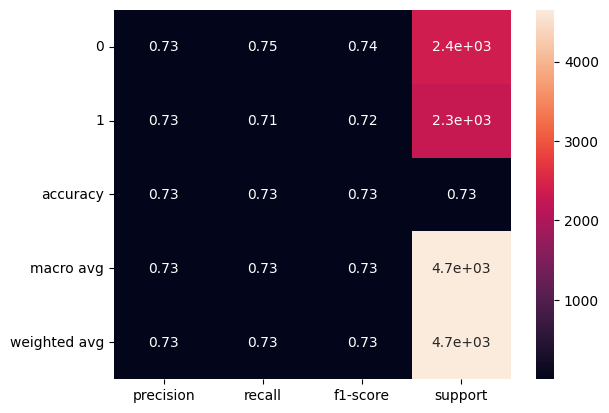

In [21]:
sns.heatmap(pd.DataFrame(classification_report(y_test, preds, output_dict=True)).T, annot=True)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

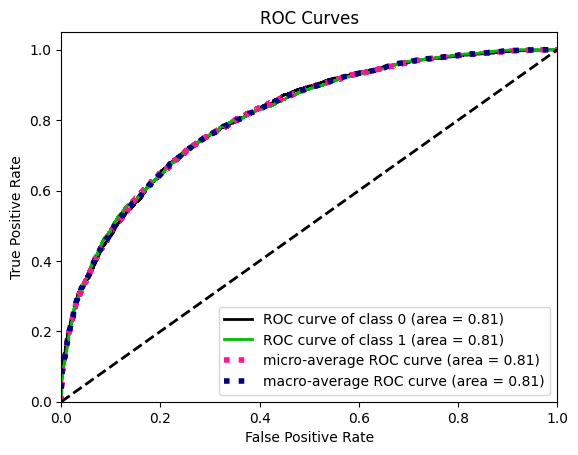

In [22]:
plot_roc_curve(y_test, np.expand_dims(probs, -1))

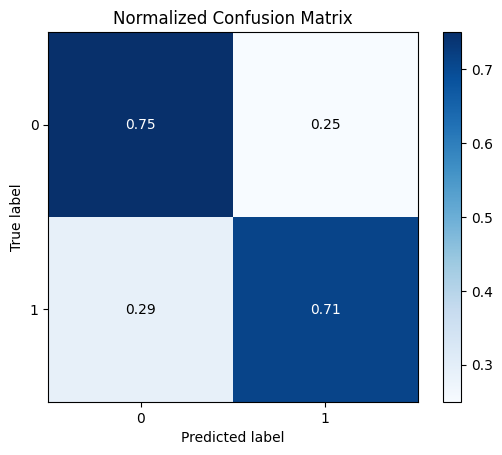

In [23]:
plot_confusion_matrix(y_test, preds, normalize='true')
plt.grid(False)